In [1]:
%pwd
%cd /Users/ashwin/Desktop/College Work/Fourth Year/L48/GroupProject/tti

/Users/ashwin/Desktop/College Work/Fourth Year/L48/GroupProject/tti


In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange
from tqdm import tqdm
import importlib

import tti_explorer
from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS
import matplotlib.pyplot as plt

%matplotlib inline

importlib.reload(tti_explorer)
importlib.reload(tti_explorer.config)
importlib.reload(tti_explorer.utils)
importlib.reload(tti_explorer.case)
importlib.reload(tti_explorer.strategies)
importlib.reload(tti_explorer.contacts)

<module 'tti_explorer.contacts' from '/Users/ashwin/Desktop/College Work/Fourth Year/L48/GroupProject/tti/tti_explorer/contacts.py'>

In [3]:
def print_doc(func):
    print(func.__doc__)

In [4]:
name = 'S3_test_based_TTI'
rng = np.random.RandomState(0)
case_config = config.get_case_config("delve")
#case_config = config.get_case_config("delve_mostly_old")
#case_config = config.get_case_config("delve_mostly_twenties")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

In [5]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [6]:
path_to_bbc_data = os.path.join("data", "processed")

child_no_school = load_csv(os.path.join(path_to_bbc_data, "childnoschool.csv"))
child_school = load_csv(os.path.join(path_to_bbc_data, "childschool.csv"))
university = load_csv(os.path.join(path_to_bbc_data, "university.csv"))
twenties = load_csv(os.path.join(path_to_bbc_data, "twenties.csv"))
thirties_to_fifties = load_csv(os.path.join(path_to_bbc_data, "thirtiestofifties.csv"))
fifties_to_seventies = load_csv(os.path.join(path_to_bbc_data, "fiftiestoseventies.csv"))
seventy_plus = load_csv(os.path.join(path_to_bbc_data, "seventyplus.csv"))

In [7]:
double_dose = False
vaccine_strategy = 'gov'
#Vaccine strategies are: none, all, gov, young_inc_children, 
#                        young_exc_children

In [8]:
simulate_contacts = EmpiricalContactsSimulator(child_no_school, child_school, university, twenties, thirties_to_fifties, fifties_to_seventies, seventy_plus, double_dose, vaccine_strategy, rng)
tti_model = TTIFlowModel(rng, **strategy_config)

In [9]:
n_seperate_starting_cases = 1000
n_repetitions = 10
outputs = list()
death_rates = []

for i in tqdm(range(n_seperate_starting_cases)):
    old_probs = []
    for i in range(n_repetitions):
        case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        (contacts, old_probs, death_rate) = simulate_contacts(case, double_dose, vaccine_strategy, None, **contacts_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
        death_rates.append(death_rate)

100%|██████████| 1000/1000 [00:14<00:00, 69.45it/s]


In [10]:
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r
]

x = pd.DataFrame(outputs).mean(0).loc[to_show].to_frame().to_numpy().flatten()
base_r = x[0]
effective_r = x[1]
relevant_death_rate_sum = sum(n for n in death_rates if n != -1)
relevant_death_rate_count = sum(1 for n in death_rates if n != -1)
dr = relevant_death_rate_sum / relevant_death_rate_count

print("Average Mortality Rate: " + str(round(dr*100,2)) + "%")
print("Base R: " + str(round(base_r, 3)))
print("Effective R: " + str(round(effective_r, 3)))

Average Mortality Rate: 3.82%
Base R: 3.524
Effective R: 1.106


In [11]:
base_r_rates = []
effective_r_rates = []
av_mortality_rates = []
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r
]

for immunity in tqdm(np.linspace(0,0.99,99)):
    n_seperate_starting_cases = 100
    n_repetitions = 10
    outputs = list()
    death_rates = []
    
    for i in range(n_seperate_starting_cases):
        old_probs = []
        for i in range(n_repetitions):
            case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            (contacts, old_probs, death_rate) = simulate_contacts(case, None, immunity, None, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            death_rates.append(death_rate)
            


    x = pd.DataFrame(outputs).mean(0).loc[to_show].to_frame().to_numpy().flatten()
    base_r_rates.append(x[0])
    effective_r_rates.append(x[1])
    relevant_death_rate_sum = sum(n for n in death_rates if n != -1)
    relevant_death_rate_count = sum(1 for n in death_rates if n != -1)
    dr = relevant_death_rate_sum / relevant_death_rate_count
    av_mortality_rates.append(dr)

print(len(base_r_rates))

100%|██████████| 99/99 [03:02<00:00,  1.84s/it]

99


ValueError: x and y must have same first dimension, but have shapes (99,) and (100,)

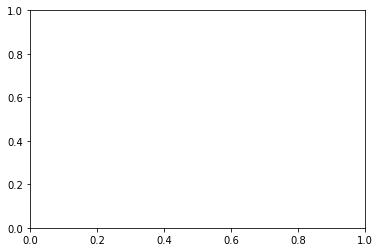

In [17]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0,.99,99), base_r_rates, color = "red", label="Base R Rates")
ax.plot(np.linspace(0,.99,99), effective_r_rates, color = "orange", label="Effective R Rates")
ax.set_xlabel("Population Immunity")
ax.set_ylabel("R rate")
ax2 = ax.twinx()  
ax2.set_ylabel("Mortality Rate")
ax2.plot(np.linspace(0,.99,99), av_mortality_rates, color = "blue", label="Mortality Rates")
ax2.set_ylim(0, 0.1)
fig.tight_layout() 
plt.figure()
plt.show()

In [13]:
# vaccine efficacy
vaccine_strategy = 'all'
#Vaccine strategies are: none, all, gov, young_inc_children, 
#                        young_exc_children

base_r_rates = []
effective_r_rates = []
av_mortality_rates = []
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r
]

for vaccine_efficacy in tqdm(np.linspace(0.2,1,100)):
    n_seperate_starting_cases = 100
    n_repetitions = 10
    outputs = list()
    death_rates = []
    
    for i in range(n_seperate_starting_cases):
        old_probs = []
        for i in range(n_repetitions):
            case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            (contacts, old_probs, death_rate) = simulate_contacts(case, False, vaccine_strategy, vaccine_efficacy, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            death_rates.append(death_rate)
            


    x = pd.DataFrame(outputs).mean(0).loc[to_show].to_frame().to_numpy().flatten()
    base_r_rates.append(x[0])
    effective_r_rates.append(x[1])
    relevant_death_rate_sum = sum(n for n in death_rates if n != -1)
    relevant_death_rate_count = sum(1 for n in death_rates if n != -1)
    dr = relevant_death_rate_sum / relevant_death_rate_count
    av_mortality_rates.append(dr)

print(len(base_r_rates))

100%|██████████| 100/100 [03:04<00:00,  1.85s/it]

100


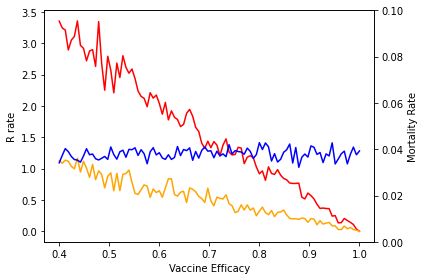

<Figure size 432x288 with 0 Axes>

In [18]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0.4,1,100), base_r_rates, color = "red", label="Base R Rates")
ax.plot(np.linspace(0.4,1,100), effective_r_rates, color = "orange", label="Effective R Rates")
ax.set_xlabel("Vaccine Efficacy")
ax.set_ylabel("R rate")
ax2 = ax.twinx()  
ax2.set_ylabel("Mortality Rate")
ax2.plot(np.linspace(0.4,1,100), av_mortality_rates, color = "blue", label="Mortality Rates")
ax2.set_ylim(0, 0.1)
fig.tight_layout() 
plt.figure()
plt.show()


In [16]:
configs = [(True, 'none'), (True, 'all'), (True, 'gov'), (True, 'young_inc_children'), (True, 'young_exc_children'),
          (False, 'none'), (False, 'all'), (False, 'gov'), (False, 'young_inc_children'), (False, 'young_exc_children')]

to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r
]

for c in configs:
    double_dose = c[0]
    vaccine_strategy = c[1]
    n_seperate_starting_cases = 100
    n_repetitions = 10
    outputs = list()
    death_rates = []
    
    for i in range(n_seperate_starting_cases):
        old_probs = []
        for i in range(n_repetitions):
            case = simulate_case(rng, p_for_categories_continued=old_probs, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            (contacts, old_probs, death_rate) = simulate_contacts(case, double_dose, vaccine_strategy, None, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            death_rates.append(death_rate)
            


    x = pd.DataFrame(outputs).mean(0).loc[to_show].to_frame().to_numpy().flatten()
    print()
    print("CONFIG: (Double Dose: " + str(c[0]) + ", Strategy: " + str(c[1]) + ")")
    print("Base R Rate: " + str(round(x[0], 2)))
    print("Effective R Rate: " + str(round(x[1], 2)))
    relevant_death_rate_sum = sum(n for n in death_rates if n != -1)
    relevant_death_rate_count = sum(1 for n in death_rates if n != -1)
    dr = relevant_death_rate_sum / relevant_death_rate_count
    print("Mortality Rate: " + str(round(dr, 4)))
    


CONFIG: (Double Dose: True, Strategy: none)
Base R Rate: 3.84
Effective R Rate: 1.15
Mortality Rate: 0.0393

CONFIG: (Double Dose: True, Strategy: all)
Base R Rate: 0.99
Effective R Rate: 0.35
Mortality Rate: 0.0392

CONFIG: (Double Dose: True, Strategy: gov)
Base R Rate: 4.73
Effective R Rate: 1.46
Mortality Rate: 0.0376

CONFIG: (Double Dose: True, Strategy: young_inc_children)
Base R Rate: 3.18
Effective R Rate: 1.02
Mortality Rate: 0.0369

CONFIG: (Double Dose: True, Strategy: young_exc_children)
Base R Rate: 3.49
Effective R Rate: 1.3
Mortality Rate: 0.0372

CONFIG: (Double Dose: False, Strategy: none)
Base R Rate: 3.93
Effective R Rate: 1.58
Mortality Rate: 0.0379

CONFIG: (Double Dose: False, Strategy: all)
Base R Rate: 1.19
Effective R Rate: 0.28
Mortality Rate: 0.0383

CONFIG: (Double Dose: False, Strategy: gov)
Base R Rate: 2.97
Effective R Rate: 1.01
Mortality Rate: 0.0387

CONFIG: (Double Dose: False, Strategy: young_inc_children)
Base R Rate: 2.74
Effective R Rate: 0.91
M